In [ ]:
# --- INSTALACIÓN ---
!pip install ortools

# --- IMPORTS ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import copy
import pickle
import glob
import tqdm
import requests
import time
# --- CONFIGURACIÓN DE DISPOSITIVO ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {DEVICE}")

# Crear carpetas necesarias
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

✅ Usando dispositivo: cuda


In [ ]:
# --- CLASES AUXILIARES ---
class TSP_Instance:
    def __init__(self, city_locations):
        self.city_locations = city_locations
        self.num_cities = len(city_locations)
        # Matriz de distancias Euclidianas
        diff = city_locations[:, np.newaxis, :] - city_locations[np.newaxis, :, :]
        self.distance_matrix = np.sqrt(np.sum(diff ** 2, axis=-1))

class TSP_State:
    def __init__(self, instance):
        self.instance = instance
        self.visited = [False] * instance.num_cities
        self.tour = [0] # Siempre empezamos en la ciudad 0
        self.visited[0] = True
        self.cost = 0.0
        self.current_city = 0

    def visit_city(self, city_idx):
        if not self.visited[city_idx]:
            dist = self.instance.distance_matrix[self.current_city][city_idx]
            self.cost += dist
            self.current_city = city_idx
            self.tour.append(city_idx)
            self.visited[city_idx] = True

# --- SOLUCIONADOR OR-TOOLS (El Maestro) ---
def solve_ortools(instance):
    # Configurar datos para OR-Tools
    # Escalamos las distancias (float -> int) porque OR-Tools trabaja mejor con enteros
    scale = 10000
    dist_matrix = (instance.distance_matrix * scale).astype(int).tolist()

    manager = pywrapcp.RoutingIndexManager(instance.num_cities, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return dist_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    solution = routing.SolveWithParameters(search_parameters)

    # Extraer solución
    route = []
    if solution:
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        # No añadimos el nodo final (que es volver al 0) para simplificar el entrenamiento
    return route


#Generar Data

In [ ]:

# --- GENERADOR DE DATASET ---
def generate_dataset(num_samples=1000, num_cities=20, filename="tsp_data.pkl"):
    print(f"🚀 Generando {num_samples} problemas de {num_cities} ciudades...")

    X_src = []   # Coordenadas
    visited = [] # Historial parcial
    Y = []       # Siguiente ciudad correcta (Target)

    for i in range(num_samples):
        # 1. Crear ciudades aleatorias
        locs = np.random.rand(num_cities, 2)
        instance = TSP_Instance(locs)

        # 2. Resolver con OR-Tools
        optimal_tour = solve_ortools(instance)

        # 3. Crear ejemplos de entrenamiento paso a paso
        # "Si he visitado [0, 5, 2], la siguiente correcta es 8"
        current_tour = [0] # Empezamos en 0

        # Recorremos la solución óptima para generar los pasos
        # optimal_tour ej: [0, 5, 2, 8, 1...]
        for target_city in optimal_tour[1:]: # Empezamos desde el segundo
            # Input: Coordenadas
            X_src.append(locs)

            # Input: Ciudades visitadas hasta ahora (con padding -1 si fuera necesario,
            # pero aquí aplanamos el dataset así que usamos listas fijas o padding luego)
            # Para simplificar y ahorrar memoria, guardaremos el estado actual como lista
            # y luego en el DataLoader haremos el padding.

            # Aquí tu compañero usó una estrategia de Padding directo:
            visit_pad = np.array(current_tour)
            visit_pad = np.pad(visit_pad, (0, num_cities - len(visit_pad)), 'constant', constant_values=-1)
            visited.append(visit_pad)

            # Output: One-Hot de la ciudad destino
            y_onehot = np.zeros(num_cities)
            y_onehot[target_city] = 1
            Y.append(y_onehot)

            # Avanzamos el estado
            current_tour.append(target_city)

        if (i+1) % 100 == 0: print(f"   Processed {i+1}/{num_samples}")

    # Guardar
    data = (np.array(X_src), np.array(visited), np.array(Y))
    with open(f"data/{filename}", "wb") as f:
        pickle.dump(data, f)
    print("✅ Dataset generado y guardado.")

# --- EJECUTAR GENERACIÓN ---
# Generamos un dataset pequeño para probar (puedes aumentar num_samples)
generate_dataset(num_samples=20000, num_cities=50, filename="tsp_train.pkl")

🚀 Generando 20000 problemas de 50 ciudades...
   Processed 100/20000
   Processed 200/20000
   Processed 300/20000
   Processed 400/20000
   Processed 500/20000
   Processed 600/20000
   Processed 700/20000
   Processed 800/20000
   Processed 900/20000
   Processed 1000/20000
   Processed 1100/20000
   Processed 1200/20000
   Processed 1300/20000
   Processed 1400/20000
   Processed 1500/20000
   Processed 1600/20000
   Processed 1700/20000
   Processed 1800/20000
   Processed 1900/20000
   Processed 2000/20000
   Processed 2100/20000
   Processed 2200/20000
   Processed 2300/20000
   Processed 2400/20000
   Processed 2500/20000
   Processed 2600/20000
   Processed 2700/20000
   Processed 2800/20000
   Processed 2900/20000
   Processed 3000/20000
   Processed 3100/20000
   Processed 3200/20000
   Processed 3300/20000
   Processed 3400/20000
   Processed 3500/20000
   Processed 3600/20000
   Processed 3700/20000
   Processed 3800/20000
   Processed 3900/20000
   Processed 4000/20000
   

#MODELO

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TSPTransformer(nn.Module):
    def __init__(
        self,
        input_dim=2,
        embed_dim=128,
        num_heads=8,
        num_encoder_layers=3, # Aumentado a 3 para más potencia
        num_glimpses=1,       # 1 suele ser suficiente y más rápido
        dropout_rate=0.1,
        dist_bias_scale=10.0  # Escala para el bias de distancia
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.dist_bias_scale = dist_bias_scale
        self.num_glimpses = num_glimpses

        # --- ENCODER ---
        self.encoder_input_layer = nn.Linear(input_dim, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout_rate,
            batch_first=True,
            norm_first=True # Pre-Norm para estabilidad
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_encoder_layers
        )

        # --- DECODER ---
        # Proyecciones
        self.ctx_fusion = nn.Linear(3 * embed_dim, embed_dim) # Context + Last + Start
        self.glimpse_proj = nn.Linear(embed_dim, embed_dim)
        self.pointer_proj = nn.Linear(embed_dim, embed_dim, bias=False)

        # Mecanismo de Atención (Glimpse)
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True
        )

        # Bloques de procesamiento del Glimpse
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Linear(4 * embed_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    # =====================================================
    # 1. --- ENCODER ---
    # =====================================================
    def encode(self, x_src):
        # x_src: [B, N, 2]
        enc_input = self.encoder_input_layer(x_src)
        memory = self.encoder(enc_input)
        return memory

    # =====================================================
    # 2. --- DECODER ---
    # =====================================================
    def decode(self, memory, coords, visited):
        """
        memory:  [B, N, Embed]
        coords:  [B, N, 2] (Coordenadas originales para distancias)
        visited: [B, N]    (Indices visitados)
        """
        B, num_cities, _ = memory.shape
        device = memory.device

        # --- MÁSCARAS ---
        # 1. Máscara de Posiciones Válidas en 'visited' (diferente de -1)
        valid_steps_mask = (visited != -1)

        # 2. Máscara de Ciudades Visitadas (Boolean: True=Visitada)
        visited_city_mask = torch.zeros(B, num_cities, dtype=torch.bool, device=device)

        # Gather seguro para índices
        batch_ids = torch.arange(B, device=device).unsqueeze(1).expand_as(visited)
        safe_vis = visited.clone().clamp(0, num_cities-1)

        # Solo marcamos las posiciones válidas
        visited_city_mask[batch_ids[valid_steps_mask], safe_vis[valid_steps_mask]] = True

        # --- CONTEXTO (Media de lo visitado) ---
        # Usamos visited_city_mask para promediar los embeddings de ciudades ya visitadas
        mask_expanded = visited_city_mask.unsqueeze(-1).float()
        sum_ctx = (memory * mask_expanded).sum(dim=1)
        count_ctx = mask_expanded.sum(dim=1).clamp(min=1)
        context_mean = sum_ctx / count_ctx

        # --- NODOS CLAVE (Start & Last) ---
        # Start Node: Siempre es el índice 0 de 'visited'
        start_node_idx = visited[:, 0].clone().clamp(0)

        # Last Node: El último elemento válido en 'visited'
        lengths = valid_steps_mask.sum(dim=1) - 1
        last_node_idx = visited.gather(1, lengths.unsqueeze(1).clamp(min=0)).squeeze(1).clamp(0)

        batch_range = torch.arange(B, device=device)
        start_emb = memory[batch_range, start_node_idx]
        last_emb = memory[batch_range, last_node_idx]

        # --- FUSIÓN DE CONTEXTO ---
        # Vector Query inicial para el decoder
        ctx_concat = torch.cat([context_mean, last_emb, start_emb], dim=-1)
        decoder_state = self.ctx_fusion(ctx_concat) # [B, Embed]

        # --- GLIMPSE LOOP (Revisar memoria) ---
        # Proyectamos query
        query = self.glimpse_proj(decoder_state).unsqueeze(1) # [B, 1, Embed]

        for _ in range(self.num_glimpses):
            # Attention (Query mira a Memory)
            attn_out, _ = self.cross_attn(
                query=query,
                key=memory,
                value=memory
                # No usamos mask aquí para que pueda ver todo el grafo y decidir mejor
            )

            # Add & Norm
            query = self.norm1(attn_out + query)

            # Feed Forward
            ff_out = self.ff(query)

            # Add & Norm
            query = self.norm2(ff_out + query)

        # El resultado del loop es nuestra 'Query Refinada'
        attn_out = query.squeeze(1)

        # --- POINTER SCORING (Compatibilidad) ---
        # Calculamos score entre Query Refinada y cada ciudad en Memoria
        ptr_query = self.pointer_proj(attn_out) # [B, Embed]

        # Matmul: [B, 1, E] x [B, E, N] -> [B, 1, N]
        scores = torch.matmul(ptr_query.unsqueeze(1), memory.transpose(1, 2)).squeeze(1)

        # Scaling
        scores = scores / math.sqrt(self.embed_dim)

        # --- DISTANCE BIAS (La "Ayuda" Geométrica) ---
        # Calculamos distancia desde Last Node a TODAS las ciudades
        last_coords = coords[batch_range, last_node_idx] # [B, 2]

        # Distancia Euclidiana: ||Coords - Last||
        # coords: [B, N, 2], last: [B, 1, 2]
        dists = torch.norm(coords - last_coords.unsqueeze(1), dim=-1) # [B, N]

        # Restamos distancia (queremos maximizar score -> minimizar distancia)
        # Multiplicamos por un escalar aprendible o fijo para equilibrar con el score de atención
        scores = scores - (dists * self.dist_bias_scale)

        # --- Tanh Clipping (Estabilidad) ---
        scores = 10 * torch.tanh(scores)

        # --- MASKING FINAL ---
        scores = scores.masked_fill(visited_city_mask, float("-inf"))

        return scores

    def forward(self, x_src, visited):
        # x_src tiene shape [B, N, 2]
        # x_src actúa como features Y como coordenadas (porque input_dim=2)
        memory = self.encode(x_src)
        return self.decode(memory, coords=x_src, visited=visited)

#Entrenamiento

In [ ]:
#Archivo entrenamiento


In [ ]:
# ==========================================
# 4. ENTRENAMIENTO MEJORADO (100 ÉPOCAS + DESCARGA AUTO)
# ==========================================
from google.colab import files # Importante para descargar

# --- CARGA DE DATOS (CON NORMALIZACIÓN) ---
def load_dataloader(filename, batch_size=64):
    with open(f"data/{filename}", "rb") as f:
        X, Visited, Y = pickle.load(f)

    # Convertir a Tensores
    X = torch.tensor(X, dtype=torch.float32)

    # APLICAR NORMALIZACIÓN [0, 1] SI ES NECESARIO
    max_val = X.max()
    if max_val > 1.0:
        print(f"⚠️ Datos no normalizados (Max={max_val:.2f}). Normalizando a [0,1]...")
        X = X / max_val

    Visited = torch.tensor(Visited, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.float32)

    dataset = TensorDataset(X, Visited, Y)

    # Split 80/20
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds, batch_size=batch_size)
    )

# --- ENTRENAMIENTO ---
def train_model(epochs=50):
    train_loader, val_loader = load_dataloader("tsp_train.pkl", batch_size=128)

    model = TSPTransformer(input_dim=2, num_encoder_layers=3, num_heads=8, embed_dim=128).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    criterion = nn.CrossEntropyLoss()

    print(f"🚀 Iniciando entrenamiento largo ({epochs} épocas)...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for bx, bvis, by in train_loader:
            bx, bvis, by = bx.to(DEVICE), bvis.to(DEVICE), by.to(DEVICE)
            optimizer.zero_grad()

            logits = model(bx, bvis)
            target_indices = by.argmax(dim=1)

            loss = criterion(logits, target_indices)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            train_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0
        val_acc = 0
        total = 0
        with torch.no_grad():
            for bx, bvis, by in val_loader:
                bx, bvis, by = bx.to(DEVICE), bvis.to(DEVICE), by.to(DEVICE)
                logits = model(bx, bvis)

                target = by.argmax(dim=1)
                loss = criterion(logits, target)
                val_loss += loss.item()

                pred = logits.argmax(dim=1)
                val_acc += (pred == target).sum().item()
                total += target.size(0)

        avg_val_loss = val_loss/len(val_loader)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc/total*100:.2f}%")

        # Guardar checkpoint y DESCARGAR cada 10 épocas
        if (epoch + 1) % 10 == 0:
            ckpt_name = f"models/tsp_transformer_ep{epoch+1}.pth"
            torch.save(model.state_dict(), ckpt_name)
            print(f"   ⬇️ Descargando checkpoint: {ckpt_name}...")
            try:
                files.download(ckpt_name)
            except Exception as e:
                print(f"   ⚠️ No se pudo descargar automáticamente: {e}")

    # Guardar y descargar modelo final
    final_name = "models/tsp_transformer.pth"
    torch.save(model.state_dict(), final_name)
    print("✅ Entrenamiento completado. Descargando modelo final...")
    try:
        files.download(final_name)
    except Exception as e:
        print(f"   ⚠️ No se pudo descargar el final: {e}")

    return model

# Entrenamos con 100 épocas
trained_model = train_model(epochs=50)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


🚀 Iniciando entrenamiento largo (50 épocas)...
Epoch 1/50 | Train Loss: 0.6663 | Val Loss: 0.5730 | Val Acc: 84.49%
Epoch 2/50 | Train Loss: 0.5655 | Val Loss: 0.5017 | Val Acc: 85.62%
Epoch 3/50 | Train Loss: 0.5304 | Val Loss: 0.4757 | Val Acc: 85.90%
Epoch 4/50 | Train Loss: 0.5099 | Val Loss: 0.4583 | Val Acc: 86.12%
Epoch 5/50 | Train Loss: 0.4958 | Val Loss: 0.4520 | Val Acc: 86.31%
Epoch 6/50 | Train Loss: 0.4847 | Val Loss: 0.4529 | Val Acc: 86.34%
Epoch 7/50 | Train Loss: 0.4761 | Val Loss: 0.4434 | Val Acc: 86.45%
Epoch 8/50 | Train Loss: 0.4686 | Val Loss: 0.4346 | Val Acc: 86.67%
Epoch 9/50 | Train Loss: 0.4622 | Val Loss: 0.4354 | Val Acc: 86.84%
Epoch 10/50 | Train Loss: 0.4564 | Val Loss: 0.4219 | Val Acc: 86.88%
   ⬇️ Descargando checkpoint: models/tsp_transformer_ep10.pth...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 11/50 | Train Loss: 0.4515 | Val Loss: 0.4271 | Val Acc: 86.86%
Epoch 12/50 | Train Loss: 0.4473 | Val Loss: 0.4177 | Val Acc: 87.05%
Epoch 13/50 | Train Loss: 0.4435 | Val Loss: 0.4155 | Val Acc: 87.09%


#Validacion con datos generados aleatoriamente


In [ ]:
def calculate_tour_length(dist_matrix, tour):
    """Calcula la distancia total del tour usando la matriz de distancias."""
    cost = 0.0
    for i in range(len(tour) - 1):
        u, v = tour[i], tour[i+1]
        cost += dist_matrix[u][v]
    # Regreso al inicio
    cost += dist_matrix[tour[-1]][tour[0]]
    return cost

def plot_tour(ax, points, tour, cost, title, color='b'):
    """Grafica la ruta encontrada."""
    # Cerrar el ciclo para el dibujo
    tour_closed = np.append(tour, tour[0])
    path = points[tour_closed]

    ax.plot(path[:, 0], path[:, 1], linestyle='-', marker='o', color=color, alpha=0.6, markersize=3)
    ax.scatter(path[0, 0], path[0, 1], c='red', s=40, zorder=10) # Inicio
    ax.set_title(f"{title}\nCosto: {cost:.4f}", fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

In [ ]:
import time
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- FUNCIONES AUXILIARES ---
def calculate_tour_length(dist_matrix, tour):
    cost = 0.0
    for i in range(len(tour) - 1):
        u, v = tour[i], tour[i+1]
        cost += dist_matrix[u][v]
    cost += dist_matrix[tour[-1]][tour[0]]
    return cost

def plot_tour(ax, points, tour, cost, title, color='b'):
    tour_closed = np.append(tour, tour[0])
    path = points[tour_closed]
    ax.plot(path[:, 0], path[:, 1], linestyle='-', marker='o', color=color, alpha=0.6, markersize=3)
    ax.scatter(path[0, 0], path[0, 1], c='red', s=40, zorder=10)
    ax.set_title(f"{title}\nCosto: {cost:.4f}", fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

# --- BEAM SEARCH VECTORIZADO ---
def solve_beam_batch(model, x, beam_width=3):
    model.eval()
    B, N, _ = x.shape

    # 1. Normalizar
    max_vals = x.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]
    x_norm = x / torch.max(max_vals, torch.tensor(1.0, device=DEVICE))

    # 2. Expandir
    x_expanded = x_norm.repeat_interleave(beam_width, dim=0)

    # 3. Inicializar
    tours = torch.zeros((B * beam_width, N), dtype=torch.long).to(DEVICE)
    visited = torch.full((B * beam_width, N), -1, dtype=torch.long).to(DEVICE)
    visited[:, 0] = 0

    beam_scores = torch.zeros((B, beam_width), device=DEVICE)
    beam_scores[:, 1:] = float('-inf')
    beam_scores = beam_scores.view(-1)

    mask = torch.zeros((B * beam_width, N), device=DEVICE)
    mask[:, 0] = float('-inf')

    batch_base_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE).unsqueeze(1)

    with torch.no_grad():
        for t in range(N - 1):
            logits = model(x_expanded, visited) + mask
            log_probs = F.log_softmax(logits, dim=1)

            curr_scores = beam_scores.unsqueeze(1) + log_probs
            curr_scores = curr_scores.view(B, beam_width * N)

            top_scores, top_indices = torch.topk(curr_scores, beam_width, dim=1)

            prev_beam_idx = top_indices // N
            next_city_idx = top_indices % N

            flat_prev_idx = (batch_base_indices + prev_beam_idx).view(-1)

            beam_scores = top_scores.view(-1)
            tours = tours[flat_prev_idx]
            visited = visited[flat_prev_idx]
            mask = mask[flat_prev_idx]

            next_cities_flat = next_city_idx.view(-1)
            tours[:, t+1] = next_cities_flat
            visited[:, t+1] = next_cities_flat
            mask.scatter_(1, next_cities_flat.unsqueeze(1), float('-inf'))

    best_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE)
    return tours[best_indices]

# --- EVALUACIÓN MEJORADA (MÁS PLOTS) ---
def evaluate_optimized(model, num_samples=100, num_cities=50, beam_width=3, batch_size=50):
    print(f"🚀 Generando {num_samples} casos (N={num_cities})...")

    # 1. Generar datos
    all_points = np.random.rand(num_samples, num_cities, 2)
    x_tensor = torch.tensor(all_points, dtype=torch.float32).to(DEVICE)

    # 2. Inferencia IA
    print(f"🧠 Ejecutando Beam Search (k={beam_width}) en GPU...")
    start_time = time.time()

    all_pred_tours = []
    for i in range(0, num_samples, batch_size):
        xb = x_tensor[i : i+batch_size]
        with torch.no_grad():
            tours_b = solve_beam_batch(model, xb, beam_width=beam_width)
        all_pred_tours.append(tours_b.cpu().numpy())

    ai_tours = np.concatenate(all_pred_tours, axis=0)
    ai_time = time.time() - start_time
    print(f"⚡ IA terminó en {ai_time:.2f}s")

    # 3. Comparación y Ploteo
    print(f"⏳ Evaluando resultados...")
    total_gap = 0.0
    perfect_count = 0
    plots_shown = 0
    MAX_PERFECT_PLOTS = 5 # Para no saturar el navegador si el modelo es muy bueno

    for i in tqdm(range(num_samples)):
        points = all_points[i]
        tour_ai = ai_tours[i]

        instance = TSP_Instance(points)
        cost_ai = calculate_tour_length(instance.distance_matrix, tour_ai)

        # OR-Tools
        tour_opt = solve_ortools(instance)
        cost_opt = calculate_tour_length(instance.distance_matrix, tour_opt)

        gap = ((cost_ai - cost_opt) / cost_opt) * 100
        total_gap += gap

        # LÓGICA DE VISUALIZACIÓN
        should_plot = False
        title_suffix = ""

        # Condición 1: Los primeros 3 casos siempre
        if i < 3:
            should_plot = True
            title_suffix = f"(Muestra {i+1})"

        # Condición 2: Si es casi perfecto (< 1%)
        elif gap < 1.0:
            perfect_count += 1
            if plots_shown < MAX_PERFECT_PLOTS + 3: # Limite de plots
                should_plot = True
                title_suffix = "🌟 PERFECTO (<1%)"

        if should_plot:
             fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
             plot_tour(axs[0], points, tour_ai, cost_ai, f"IA {title_suffix}", 'blue')
             plot_tour(axs[1], points, tour_opt, cost_opt, "Óptimo", 'green')
             plt.tight_layout()
             plt.show()
             plots_shown += 1

    print(f"\n📊 RESULTADO FINAL (N={num_cities}):")
    print(f"   Gap Promedio: {total_gap/num_samples:.2f}%")
    print(f"   Casos Perfectos (<1%): {perfect_count}/{num_samples} ({perfect_count/num_samples*100:.1f}%)")


# Cargar y Ejecutar
if 'trained_model' in globals():
    model_eval = trained_model
else:
    model_eval = TSPTransformer(num_layers=3, num_heads=8, embed_dim=128).to(DEVICE)
    model_eval.load_state_dict(torch.load("models/tsp_transformer.pth", map_location=DEVICE))

# Prueba con N=35
evaluate_optimized(model_eval, num_samples= 100, num_cities=200, beam_width=1)

TypeError: TSPTransformer.__init__() got an unexpected keyword argument 'num_layers'

#VALIDACION CON LA DATA DE GIHUB


In [ ]:
import os


# --- CONFIGURACIÓN ---
REPO_USER = "felipe-astudillo-s"
REPO_NAME = "TransformerTSP"
BRANCH = "main"

VAL_FOLDERS = {
    "EASY":   {"gh_path": "Data/Validation/Easy",   "prefix": "tsp_easy"},
    "MEDIUM": {"gh_path": "Data/Validation/Medium", "prefix": "tsp_medium"},
    "HARD":   {"gh_path": "Data/Validation/Hard",   "prefix": "tsp_hard"}
}

# Variable Global para almacenar datos en RAM
GLOBAL_DATA = {}

def download_and_load():
    print("📦 Iniciando descarga y carga de datos...")

    for phase, cfg in VAL_FOLDERS.items():
        print(f"   🔹 Cargando Fase: {phase}...")
        local_dir = f"val_data/{phase}"
        os.makedirs(local_dir, exist_ok=True)

        # 1. Obtener lista de archivos de GitHub API
        api_url = f"https://api.github.com/repos/{REPO_USER}/{REPO_NAME}/contents/{cfg['gh_path']}?ref={BRANCH}"
        try:
            resp = requests.get(api_url)
            if resp.status_code != 200:
                print(f"      ⚠️ Error accediendo a GitHub: {resp.status_code}"); continue
            files = resp.json()
        except: print("      ⚠️ Error de conexión."); continue

        # 2. Descargar y cargar en lista
        all_points, all_sols = [], []

        count = 0
        for item in files:
            if item['name'].endswith('.npz') and item['name'].startswith(cfg['prefix']):
                local_path = os.path.join(local_dir, item['name'])

                # Descargar si no existe
                if not os.path.exists(local_path):
                    with open(local_path, 'wb') as f:
                        f.write(requests.get(item['download_url']).content)

                # Cargar en memoria
                data = np.load(local_path, allow_pickle=True)
                pts = data['points'] # [B, N, 2]
                sols = data['solutions']

                # Uniformar formato de soluciones
                if sols.dtype == np.object_:
                    sols = np.vstack(sols).astype(np.int64)
                else:
                    sols = sols.astype(np.int64)

                # Padding standard a 100 para guardar en array uniforme
                B, N, _ = pts.shape
                pad = 100 - N
                if pad > 0:
                    pts = np.pad(pts, ((0,0), (0,pad), (0,0)), 'constant')
                    sols = np.pad(sols, ((0,0), (0,pad)), 'constant', constant_values=-1)

                all_points.append(pts)
                all_sols.append(sols)
                count += 1

        if all_points:
            GLOBAL_DATA[phase] = {
                'X': np.concatenate(all_points),
                'Y': np.concatenate(all_sols)
            }
            print(f"      ✅ {count} archivos cargados. Total casos: {len(GLOBAL_DATA[phase]['X'])}")
        else:
            print("      ⚠️ No se encontraron archivos .npz")

    print("\n✨ Carga completa. Datos listos en GLOBAL_DATA.")

# Ejecutar carga
download_and_load()

📦 Iniciando descarga y carga de datos...
   🔹 Cargando Fase: EASY...
      ✅ 10 archivos cargados. Total casos: 1000
   🔹 Cargando Fase: MEDIUM...
      ✅ 10 archivos cargados. Total casos: 1000
   🔹 Cargando Fase: HARD...
      ✅ 5 archivos cargados. Total casos: 500

✨ Carga completa. Datos listos en GLOBAL_DATA.


#GREEDY

In [ ]:

# --- CONFIGURACIÓN ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEAM_WIDTH = 1
BATCH_SIZE = 64
MAX_PLOTS = 6

# --- BEAM SEARCH VECTORIZADO (El Rápido) ---
def solve_beam_batch(model, x, beam_width=3):
    """Procesa un batch entero [B, N, 2] simultáneamente."""
    model.eval()
    B, N, _ = x.shape

    # 1. Normalizar
    max_vals = x.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]
    x_norm = x / torch.max(max_vals, torch.tensor(1.0, device=DEVICE))

    # 2. Expandir
    x_expanded = x_norm.repeat_interleave(beam_width, dim=0)

    # 3. Inicializar
    tours = torch.zeros((B * beam_width, N), dtype=torch.long).to(DEVICE)
    visited = torch.full((B * beam_width, N), -1, dtype=torch.long).to(DEVICE)
    visited[:, 0] = 0

    beam_scores = torch.zeros((B, beam_width), device=DEVICE)
    beam_scores[:, 1:] = float('-inf')
    beam_scores = beam_scores.view(-1)

    mask = torch.zeros((B * beam_width, N), device=DEVICE)
    mask[:, 0] = float('-inf')

    batch_base_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE).unsqueeze(1)

    with torch.no_grad():
        for t in range(N - 1):
            logits = model(x_expanded, visited) + mask
            log_probs = F.log_softmax(logits, dim=1)

            curr_scores = beam_scores.unsqueeze(1) + log_probs
            curr_scores = curr_scores.view(B, beam_width * N)

            top_scores, top_indices = torch.topk(curr_scores, beam_width, dim=1)

            prev_beam_idx = top_indices // N
            next_city_idx = top_indices % N

            flat_prev_idx = (batch_base_indices + prev_beam_idx).view(-1)

            beam_scores = top_scores.view(-1)
            tours = tours[flat_prev_idx]
            visited = visited[flat_prev_idx]
            mask = mask[flat_prev_idx]

            next_cities_flat = next_city_idx.view(-1)
            tours[:, t+1] = next_cities_flat
            visited[:, t+1] = next_cities_flat
            mask.scatter_(1, next_cities_flat.unsqueeze(1), float('-inf'))

    best_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE)
    return tours[best_indices]

# --- DISTANCIA ---
def calc_dist(points, tour_idx):
    if points.device != tour_idx.device: tour_idx = tour_idx.to(points.device)
    valid_idx = tour_idx.clone()
    valid_idx[valid_idx == -1] = 0
    ordered = torch.gather(points, 1, valid_idx.unsqueeze(-1).expand(-1, -1, 2))
    diff = ordered - torch.roll(ordered, -1, dims=1)
    dist = torch.norm(diff, dim=2).sum(dim=1)
    return dist

# --- PLOT ---
def plot_val_case(ax, points, tour, cost, title, color):
    valid_tour = tour.tolist()
    if len(valid_tour) > 0: valid_tour.append(valid_tour[0])
    path = points[valid_tour]
    ax.plot(path[:,0], path[:,1], 'o-', color=color, alpha=0.6, markersize=3)
    ax.scatter(path[0,0], path[0,1], c='red', s=50, label='Start', zorder=10)
    ax.set_title(f"{title}\nCosto: {cost:.4f}", fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

🚀 COMPARATIVA: IA vs OPTIMO vs GREEDY (Beam=1)

🔹 FASE: EASY
   🐢 Calculando Greedy NN...
   🧠 Calculando IA (Beam Search)...


100%|██████████| 16/16 [00:01<00:00, 10.57it/s]
/tmp/ipython-input-1797421736.py:160: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


------------------------------
   📊 RESULTADOS (N=20):
   🔴 Gap Greedy: 17.26%  (Baseline)
   🔵 Gap IA:     4.99%  (Tu Modelo)
   ✨ Mejora sobre Greedy: 12.27 puntos porcentuales
------------------------------


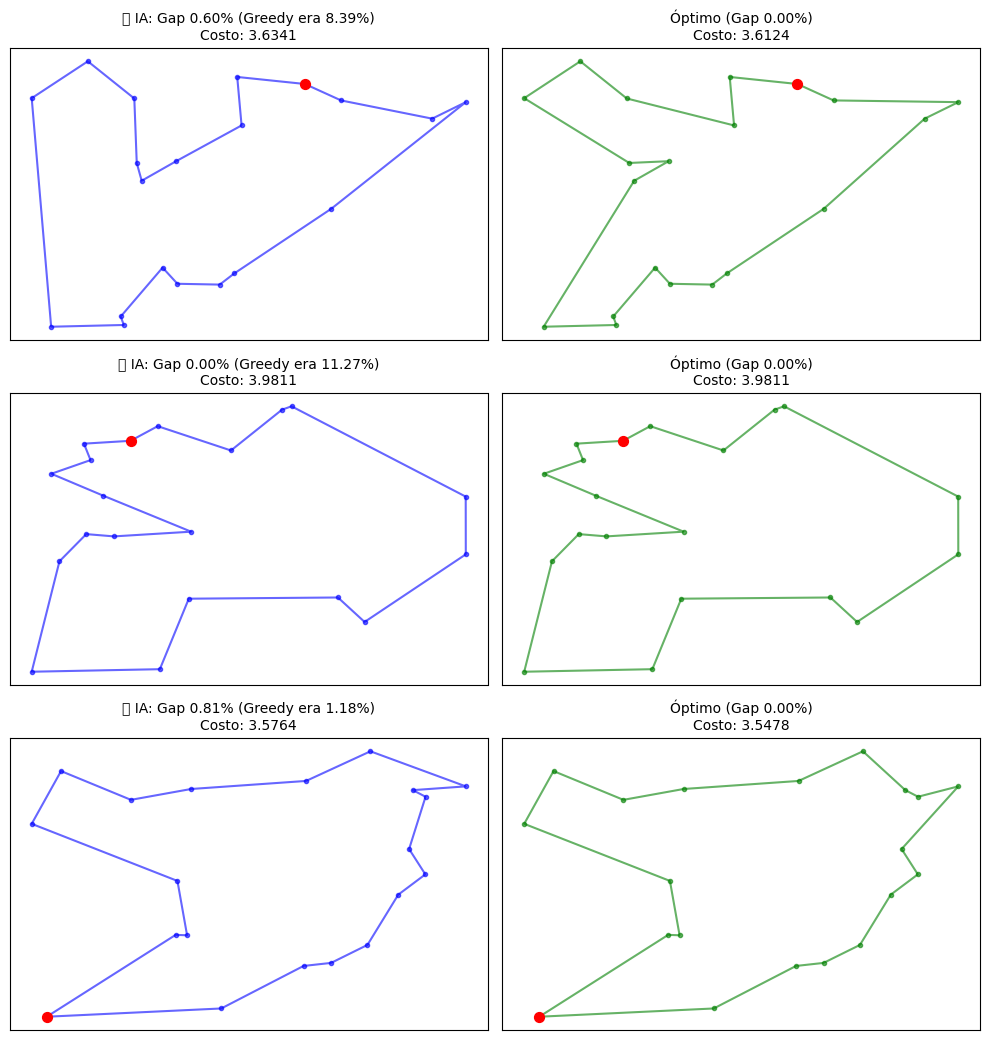


🔹 FASE: MEDIUM
   🐢 Calculando Greedy NN...
   🧠 Calculando IA (Beam Search)...


100%|██████████| 16/16 [00:05<00:00,  3.07it/s]


------------------------------
   📊 RESULTADOS (N=50):
   🔴 Gap Greedy: 21.27%  (Baseline)
   🔵 Gap IA:     6.22%  (Tu Modelo)
   ✨ Mejora sobre Greedy: 15.05 puntos porcentuales
------------------------------


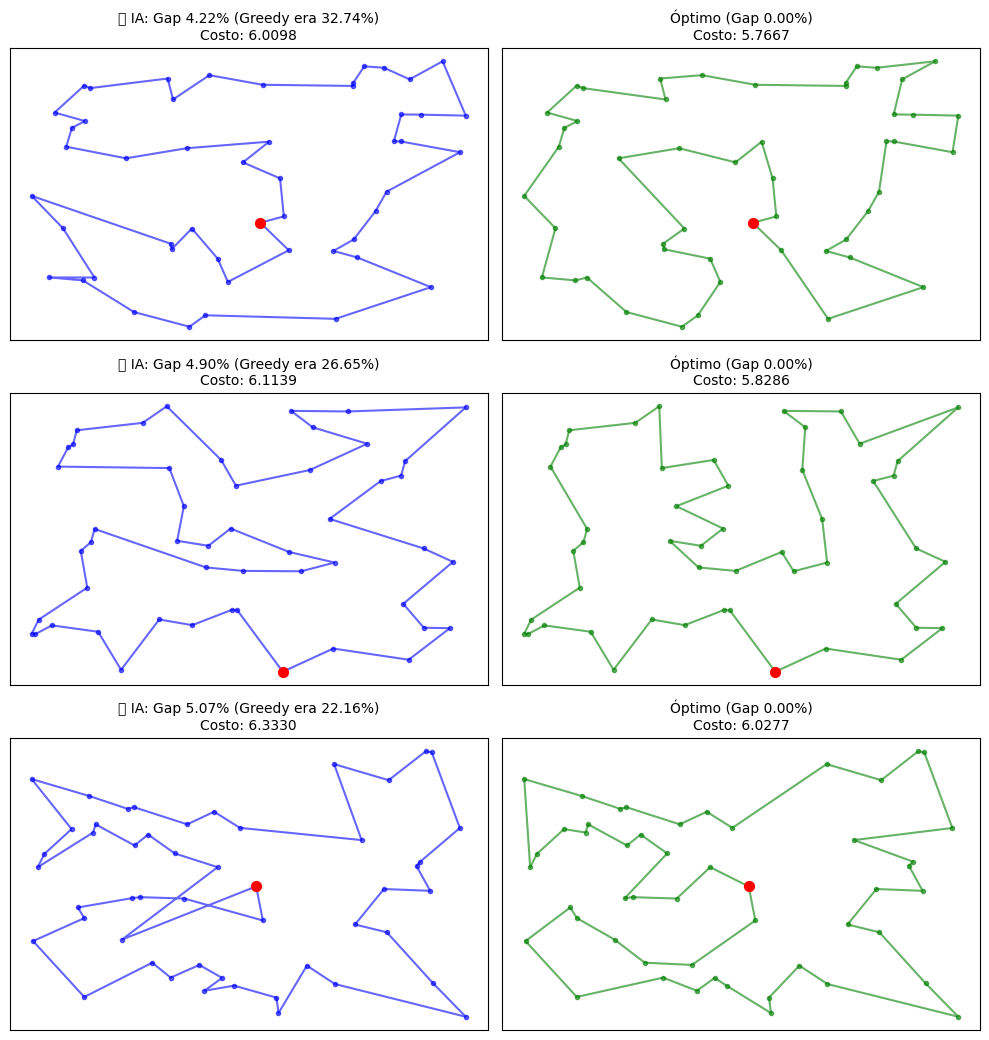


🔹 FASE: HARD
   🐢 Calculando Greedy NN...
   🧠 Calculando IA (Beam Search)...


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


------------------------------
   📊 RESULTADOS (N=100):
   🔴 Gap Greedy: 21.17%  (Baseline)
   🔵 Gap IA:     8.78%  (Tu Modelo)
   ✨ Mejora sobre Greedy: 12.39 puntos porcentuales
------------------------------


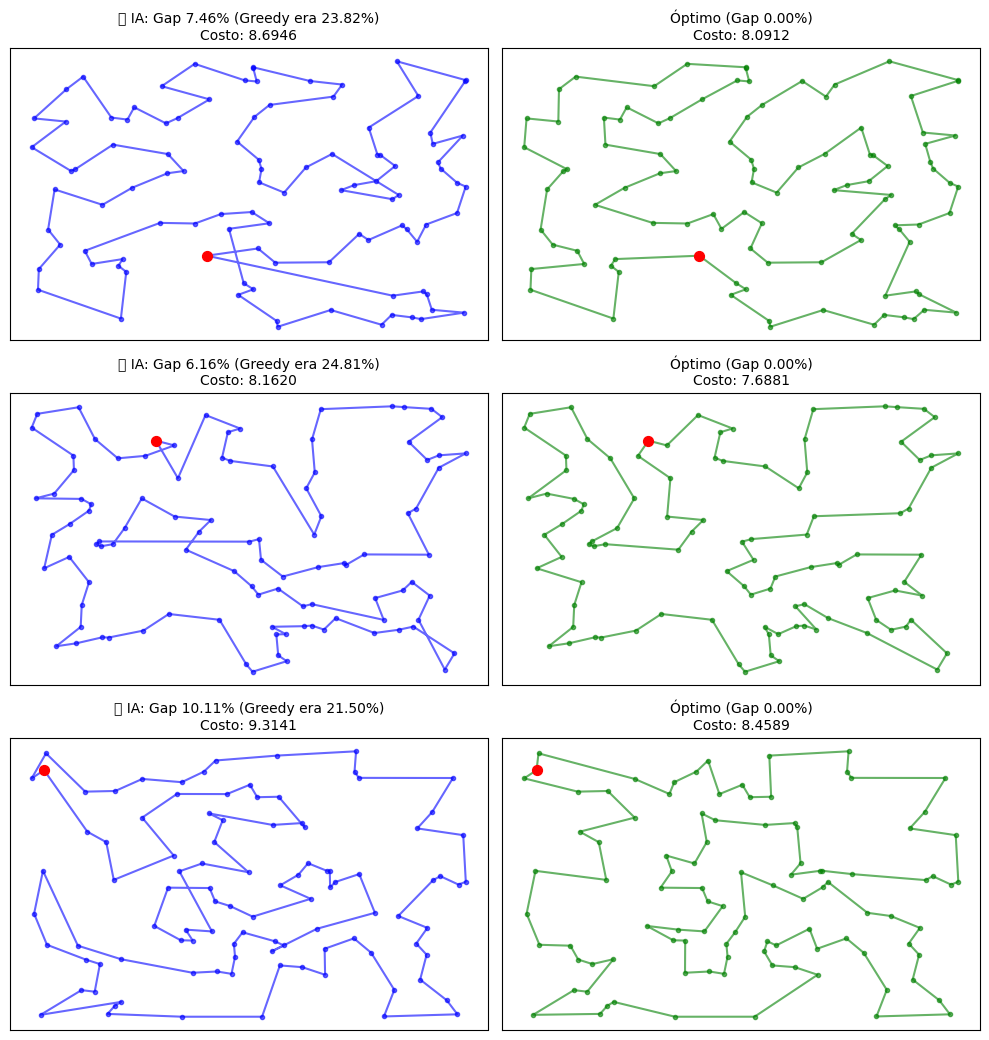

In [ ]:
# ==========================================
# 5-A. VALIDACIÓN RÁPIDA (VS GREEDY NN)
# ==========================================

# --- ALGORITMO GREEDY (Vecino más cercano) ---
def solve_greedy_batch(x):
    """
    Resuelve TSP usando la heurística Greedy Nearest Neighbor.
    x: [B, N, 2]
    """
    B, N, _ = x.shape
    device = x.device

    # Matriz de distancias [B, N, N]
    # (x^2 + y^2 - 2xy)
    dists = torch.cdist(x, x, p=2)

    # Enmascarar diagonal (distancia a sí mismo = inf)
    dists.diagonal(dim1=-2, dim2=-1).fill_(float('inf'))

    current_city = torch.zeros(B, dtype=torch.long, device=device)
    tour = [current_city]

    # Máscara de visitados
    visited_mask = torch.zeros(B, N, dtype=torch.bool, device=device)
    batch_indices = torch.arange(B, device=device)
    visited_mask[batch_indices, current_city] = True

    for _ in range(N - 1):
        # Seleccionar distancias desde la ciudad actual
        # d_curr: [B, N]
        d_curr = dists[batch_indices, current_city]

        # Poner infinito en las ya visitadas
        d_curr[visited_mask] = float('inf')

        # Elegir la más cercana
        next_city = d_curr.argmin(dim=1)

        current_city = next_city
        visited_mask[batch_indices, current_city] = True
        tour.append(current_city)

    return torch.stack(tour, dim=1)

# --- EJECUCIÓN RÁPIDA MEJORADA ---
def run_fast_evaluation():
    if not GLOBAL_DATA:
        print("❌ Primero ejecuta el Bloque 5-A para cargar los datos.")
        return

    # Cargar Modelo
    model_path = "models/tsp_transformer.pth" # Usa el mejor guardado
    if not os.path.exists(model_path):
        print("⚠️ No encuentro el modelo.")
        return

    # IMPORTANTE: Asegúrate de que estos parámetros coincidan con tu entrenamiento
    model = TSPTransformer(input_dim=2, num_encoder_layers=3, num_heads=8, embed_dim=128).to(DEVICE)

    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    except Exception as e:
        print(f"❌ Error cargando pesos: {e}")
        return

    model.eval()

    print(f"🚀 COMPARATIVA: IA vs OPTIMO vs GREEDY (Beam={BEAM_WIDTH})")

    for phase, data in GLOBAL_DATA.items():
        print(f"\n{'='*60}")
        print(f"🔹 FASE: {phase}")

        X_all = data['X']
        Y_all = data['Y']

        # Detección N
        sample_y = Y_all[0]
        n_real = np.sum(sample_y != -1)
        if n_real < 5: n_real = X_all.shape[1]

        # Seleccionar muestras
        num_samples = min(1000, len(X_all))
        X_np = X_all[:num_samples, :n_real, :]
        Y_np = Y_all[:num_samples, :n_real]

        # Tensores
        if X_np.max() > 1.0: X_np /= X_np.max()
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

        # 1. SOLUCIÓN GREEDY (BASELINE)
        print(f"   🐢 Calculando Greedy NN...")
        tours_greedy = solve_greedy_batch(X_tensor)
        dist_greedy = calc_dist(X_tensor, tours_greedy)

        # 2. SOLUCIÓN IA (MODELO)
        print(f"   🧠 Calculando IA (Beam Search)...")
        all_pred_tours = []
        for i in tqdm(range(0, num_samples, BATCH_SIZE)):
            xb = X_tensor[i : i+BATCH_SIZE]
            with torch.no_grad():
                tour_b = solve_beam_batch(model, xb, beam_width=BEAM_WIDTH)
            all_pred_tours.append(tour_b)
        pred_tours = torch.cat(all_pred_tours, dim=0)
        dist_ai = calc_dist(X_tensor, pred_tours)

        # 3. SOLUCIÓN ÓPTIMA (GROUND TRUTH)
        Y_tensor = torch.tensor(Y_np, dtype=torch.long).to(DEVICE)
        Y_clean = Y_tensor.clone(); Y_clean[Y_clean == -1] = 0
        dist_opt = calc_dist(X_tensor, Y_clean)

        # --- CÁLCULO DE GAPS ---
        mask_valid = dist_opt > 0

        # Gap IA
        gap_ai = torch.zeros_like(dist_opt)
        gap_ai[mask_valid] = ((dist_ai[mask_valid] - dist_opt[mask_valid]) / dist_opt[mask_valid]) * 100

        # Gap Greedy
        gap_greedy = torch.zeros_like(dist_opt)
        gap_greedy[mask_valid] = ((dist_greedy[mask_valid] - dist_opt[mask_valid]) / dist_opt[mask_valid]) * 100

        print("-" * 30)
        print(f"   📊 RESULTADOS (N={n_real}):")
        print(f"   🔴 Gap Greedy: {gap_greedy.mean().item():.2f}%  (Baseline)")
        print(f"   🔵 Gap IA:     {gap_ai.mean().item():.2f}%  (Tu Modelo)")

        improvement = gap_greedy.mean().item() - gap_ai.mean().item()
        print(f"   ✨ Mejora sobre Greedy: {improvement:.2f} puntos porcentuales")
        print("-" * 30)

        # --- PLOTS ---
        # Mostramos: Izquierda (IA), Derecha (Optimal).
        # En el título de la IA ponemos qué tan mejor fue que el Greedy.
        plots_data = []
        for i in range(min(3, num_samples)):
            plots_data.append({'idx': i, 'label': f"Muestra {i+1}"})

        if plots_data:
            rows = len(plots_data)
            fig, axs = plt.subplots(rows, 2, figsize=(10, 3.5 * rows))
            if rows == 1: axs = np.expand_dims(axs, 0)

            for k, item in enumerate(plots_data):
                idx = item['idx']

                # Datos para este caso
                g_val = gap_greedy[idx].item()
                ai_val = gap_ai[idx].item()

                # Título dinámico
                title_ai = f"IA: Gap {ai_val:.2f}% (Greedy era {g_val:.2f}%)"
                if ai_val < g_val: title_ai = "✅ " + title_ai
                else: title_ai = "⚠️ " + title_ai

                plot_val_case(axs[k, 0], X_np[idx], pred_tours[idx].cpu().numpy(), dist_ai[idx].item(), title_ai, 'blue')
                plot_val_case(axs[k, 1], X_np[idx], Y_np[idx], dist_opt[idx].item(), f"Óptimo (Gap 0.00%)", 'green')

            plt.tight_layout()
            plt.show()

run_fast_evaluation()

#Con rotacion


🚀 EVALUACIÓN CON ROTATION AUGMENTATION (TTA x8)
   (Probamos 8 variaciones de cada mapa y nos quedamos la mejor)

🔹 FASE: EASY
   🧠 Procesando 1000 mapas x 8 vistas...


100%|██████████| 63/63 [00:07<00:00,  8.49it/s]


   📊 GAP TTA (x8): 1.00%


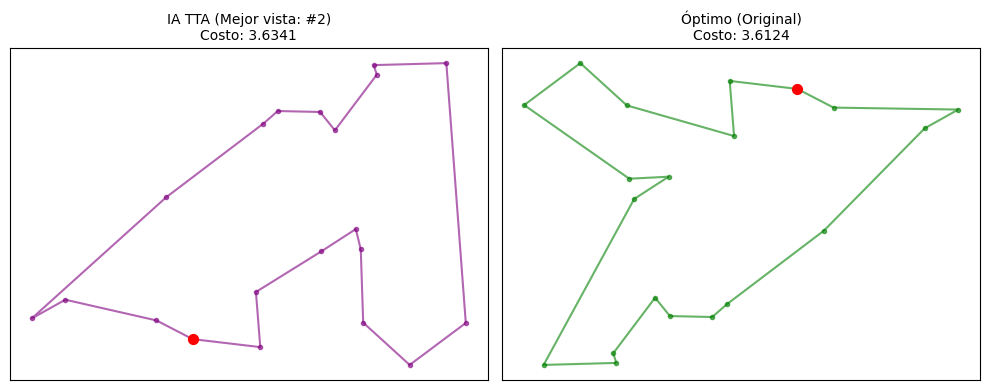


🔹 FASE: MEDIUM
   🧠 Procesando 1000 mapas x 8 vistas...


100%|██████████| 63/63 [00:36<00:00,  1.73it/s]

   📊 GAP TTA (x8): 1.69%


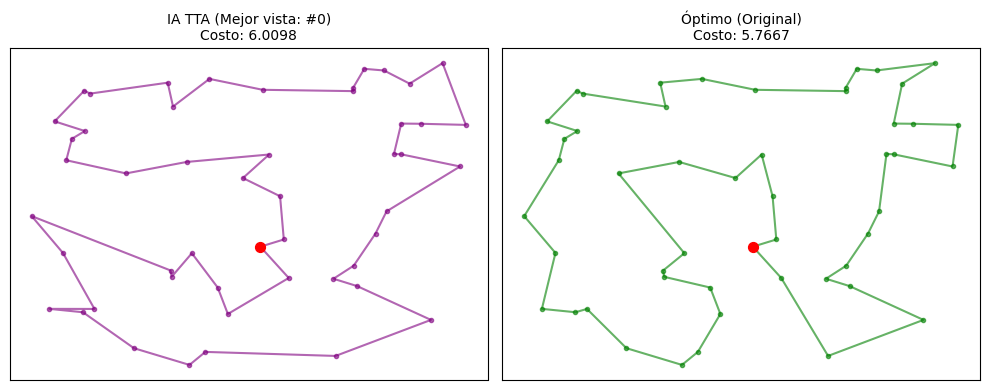


🔹 FASE: HARD
   🧠 Procesando 500 mapas x 8 vistas...


100%|██████████| 32/32 [01:11<00:00,  2.23s/it]

   📊 GAP TTA (x8): 4.16%


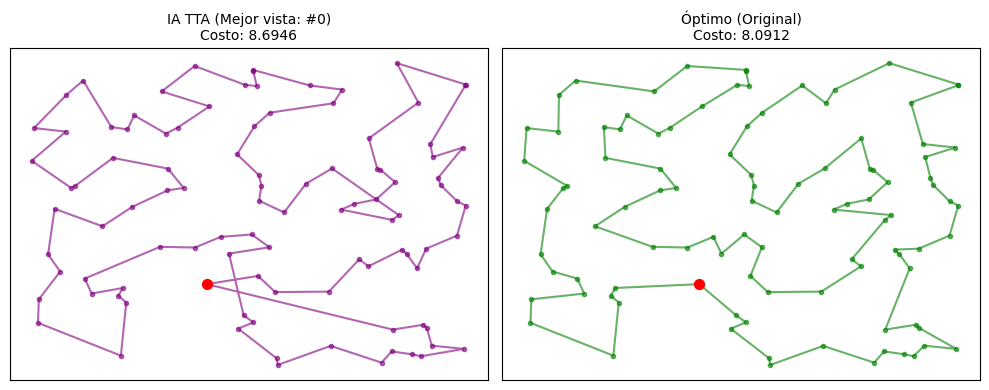

In [ ]:
# ==========================================
# 5-D. VALIDACIÓN PRO (TEST-TIME AUGMENTATION x8)
# ==========================================

def augment_8_fold(x):
    """
    Genera 8 simetrías para un batch de mapas [B, N, 2].
    Retorna: [B * 8, N, 2]
    Asume que x está normalizado aprox en [0, 1].
    """
    B, N, _ = x.shape
    x_aug = x.repeat(8, 1, 1) # [8B, N, 2]

    # Separamos x e y para manipularlos
    # x_aug está organizado como: [B_orig, B_rot90, ..., B_flip, ...]

    # 0: Original (x, y)

    # 1: Rot 90 (y, 1-x) -> x_new=y, y_new=1-x
    x_aug[B:2*B, :, 0] = x[:, :, 1]
    x_aug[B:2*B, :, 1] = 1.0 - x[:, :, 0]

    # 2: Rot 180 (1-x, 1-y)
    x_aug[2*B:3*B, :, 0] = 1.0 - x[:, :, 0]
    x_aug[2*B:3*B, :, 1] = 1.0 - x[:, :, 1]

    # 3: Rot 270 (1-y, x)
    x_aug[3*B:4*B, :, 0] = 1.0 - x[:, :, 1]
    x_aug[3*B:4*B, :, 1] = x[:, :, 0]

    # --- ESPEJOS (Transponer primero) ---
    # Base Flip: (y, x)
    x_flip = torch.stack([x[:, :, 1], x[:, :, 0]], dim=-1)

    # 4: Flip (y, x)
    x_aug[4*B:5*B] = x_flip

    # 5: Flip + Rot 90 (x, 1-y)
    x_aug[5*B:6*B, :, 0] = x_flip[:, :, 1]
    x_aug[5*B:6*B, :, 1] = 1.0 - x_flip[:, :, 0]

    # 6: Flip + Rot 180 (1-y, 1-x)
    x_aug[6*B:7*B, :, 0] = 1.0 - x_flip[:, :, 0]
    x_aug[6*B:7*B, :, 1] = 1.0 - x_flip[:, :, 1]

    # 7: Flip + Rot 270 (1-x, y)
    x_aug[7*B:8*B, :, 0] = 1.0 - x_flip[:, :, 1]
    x_aug[7*B:8*B, :, 1] = x_flip[:, :, 0]

    return x_aug

def run_tta_evaluation():
    if not GLOBAL_DATA:
        print("❌ Primero ejecuta el Bloque 5-A para cargar los datos.")
        return

    # Cargar Modelo
    model_path = "models/tsp_transformer.pth"
    if not os.path.exists(model_path):
        print("⚠️ No encuentro el modelo.")
        return

    # Asegúrate de usar la configuración correcta de tu modelo entrenado
    model = TSPTransformer(input_dim=2, num_encoder_layers=3, num_heads=8, embed_dim=128).to(DEVICE)
    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    except:
        print("❌ Error cargando pesos.")
        return

    model.eval()

    print(f"🚀 EVALUACIÓN CON ROTATION AUGMENTATION (TTA x8)")
    print(f"   (Probamos 8 variaciones de cada mapa y nos quedamos la mejor)")

    for phase, data in GLOBAL_DATA.items():
        print(f"\n{'='*60}")
        print(f"🔹 FASE: {phase}")

        X_all = data['X']
        Y_all = data['Y']

        # Detección N y Selección de muestras
        sample_y = Y_all[0]
        n_real = np.sum(sample_y != -1)
        if n_real < 5: n_real = X_all.shape[1]

        num_samples = min(1000, len(X_all)) # 500 muestras x 8 variaciones = 4000 inferencias
        X_np = X_all[:num_samples, :n_real, :]
        Y_np = Y_all[:num_samples, :n_real]

        if X_np.max() > 1.0: X_np /= X_np.max()
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

        # --- BUCLE TTA ---
        print(f"   🧠 Procesando {num_samples} mapas x 8 vistas...")

        # Guardaremos las distancias mínimas encontradas
        best_dists = []
        best_tours_plot = [] # Para plotear algunos ejemplos

        # Reducimos batch size porque multiplicamos data x8
        tta_batch_size = 16

        for i in tqdm(range(0, num_samples, tta_batch_size)):
            xb = X_tensor[i : i+tta_batch_size] # [B, N, 2]
            current_bs = xb.shape[0]

            # 1. Augmentar x8
            xb_aug = augment_8_fold(xb) # [B*8, N, 2]

            # 2. Inferencia (Beam Search normal)
            with torch.no_grad():
                # Usamos el solver vectorizado que ya tienes
                tours_aug = solve_beam_batch(model, xb_aug, beam_width=BEAM_WIDTH) # [B*8, N]

            # 3. Calcular distancias
            # Nota: La distancia euclidiana es invariante a la rotación.
            # No necesitamos "des-rotar" el tour para saber su largo.
            dists_aug = calc_dist(xb_aug, tours_aug) # [B*8]

            # 4. Seleccionar el mejor de los 8
            dists_reshaped = dists_aug.view(8, current_bs).transpose(0, 1) # [B, 8]
            min_dists, min_idxs = dists_reshaped.min(dim=1) # [B]

            best_dists.append(min_dists)

            # (Opcional) Guardar el tour ganador para plotear el primero del batch
            if i == 0:
                # El mejor tour de la primera muestra
                best_version = min_idxs[0].item() # 0..7
                # Recuperamos ese tour específico
                # El índice en el batch aplanado es: best_version * current_bs + 0
                flat_idx = best_version * current_bs
                # Pero xb_aug está organizado [B_orig, B_rot...].
                # Para la muestra 0, sus versiones están en los índices: 0, B, 2B...
                # Ajuste: augment_8_fold devuelve [8*B...].
                # El índice de la muestra 'k' en la versión 'v' es: v * B + k
                idx_in_aug = best_version * current_bs + 0

                # Necesitamos des-rotar las coordenadas para el plot para que coincidan con la original?
                # Visualmente es mejor plotear el mapa rotado ganador directamente.
                best_tours_plot.append({
                    'coords': xb_aug[idx_in_aug].cpu().numpy(),
                    'tour': tours_aug[idx_in_aug].cpu().numpy(),
                    'cost': min_dists[0].item(),
                    'version': best_version
                })

        # Concatenar resultados
        dist_model = torch.cat(best_dists)

        # Baseline Óptimo
        Y_tensor = torch.tensor(Y_np, dtype=torch.long).to(DEVICE)
        Y_clean = Y_tensor.clone(); Y_clean[Y_clean == -1] = 0
        dist_opt = calc_dist(X_tensor, Y_clean)

        # Gaps
        gap = ((dist_model - dist_opt) / dist_opt) * 100
        print(f"   📊 GAP TTA (x8): {gap.mean().item():.2f}%")

        # Comparar con Greedy (Opcional, para ver mejora)
        # gap_greedy = ... (ya lo sabes)

        # Plot del mejor caso encontrado para la primera muestra
        if best_tours_plot:
            idx = 0
            best_case = best_tours_plot[0]
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))

            # Plot IA (Mapa Rotado Ganador)
            plot_val_case(axs[0], best_case['coords'], best_case['tour'], best_case['cost'], f"IA TTA (Mejor vista: #{best_case['version']})", 'purple')

            # Plot Optimo (Mapa Original)
            plot_val_case(axs[1], X_np[idx], Y_np[idx], dist_opt[idx].item(), "Óptimo (Original)", 'green')

            plt.tight_layout()
            plt.show()

run_tta_evaluation()

#Con sampling


📂 Modelo cargado: models/tsp_transformer.pth
🎲 INICIANDO EVALUACIÓN SAMPLING (Best of 500)

🔹 FASE: EASY
 🧠 Procesando 1000 mapas con 500 intentos c/u...


100%|██████████| 16/16 [00:13<00:00,  1.21it/s]

 📊 GAP SAMPLING: 0.15%
 🏆 Perfectos: 772/1000 (77.2%)


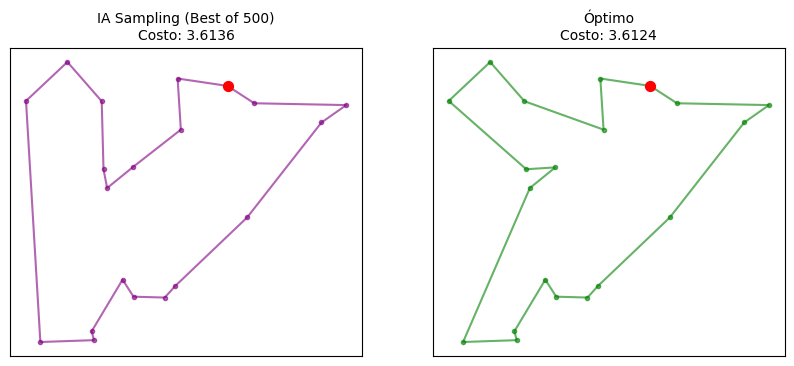


🔹 FASE: MEDIUM
 🧠 Procesando 1000 mapas con 500 intentos c/u...


100%|██████████| 16/16 [01:14<00:00,  4.63s/it]

 📊 GAP SAMPLING: 0.61%
 🏆 Perfectos: 319/1000 (31.9%)


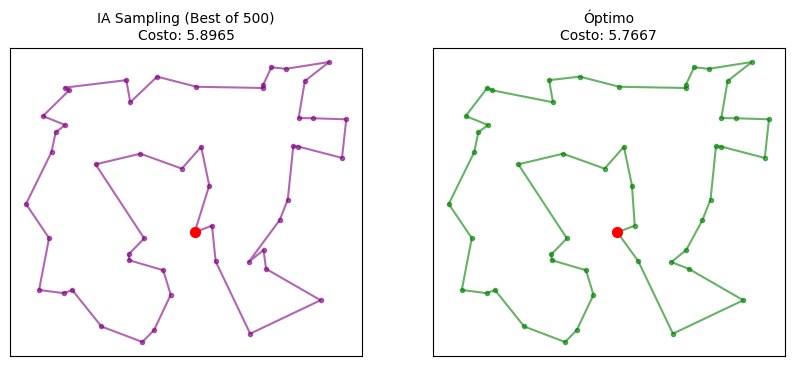


🔹 FASE: HARD
 🧠 Procesando 500 mapas con 500 intentos c/u...


100%|██████████| 8/8 [02:21<00:00, 17.63s/it]

 📊 GAP SAMPLING: 13.13%
 🏆 Perfectos: 0/500 (0.0%)


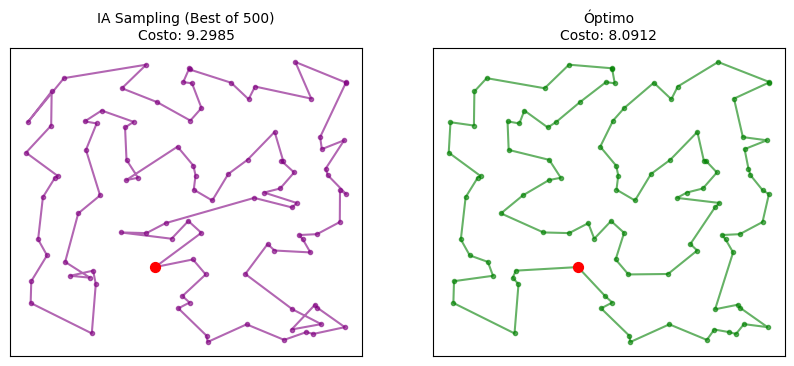

In [ ]:
# ==========================================
# 5-C. VALIDACIÓN DE ALTO RENDIMIENTO (SAMPLING)
# ==========================================

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# --- CONFIGURACIÓN DE SAMPLING ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64      # Un poco más pequeño porque expandimos memoria
NUM_SAMPLES = 500    # 100 intentos por mapa (El estándar para papers es 1280, pero 100 está bien para probar)
TEMPERATURE = 1.0   # 1.0 = Normal. <1.0 = Conservador. >1.0 = Arriesgado.

# --- SOLVER SAMPLING VECTORIZADO (Usando decode del modelo) ---
def solve_sampling_batch_fast(model, x, num_samples=100, temp=1.0):
    """
    Genera 'num_samples' rutas por cada mapa en 'x' y devuelve la mejor.
    """
    model.eval()
    B, N, _ = x.shape

    # 1. ENCODER (Solo una vez)
    # Normalizamos (Si el modelo fue entrenado con datos normalizados)
    # Asumimos que x viene crudo, normalizamos si es necesario o si el modelo lo espera
    # Si usaste load_dataloader simple que no normaliza mucho, esto está bien.

    with torch.no_grad():
        memory_base = model.encode(x) # [B, N, Embed]

    # 2. EXPANSIÓN (Multiplicar datos en RAM)
    # [B, N, E] -> [B * S, N, E]
    memory = memory_base.repeat_interleave(num_samples, dim=0)
    # Tambien necesitamos las coords expandidas para el 'Distance Bias' del decoder
    coords_expanded = x.repeat_interleave(num_samples, dim=0)

    B_eff = B * num_samples # Batch efectivo (ej: 64 * 100 = 6400)

    # 3. ESTADO INICIAL
    tours = torch.zeros((B_eff, N), dtype=torch.long).to(DEVICE)
    visited = torch.full((B_eff, N), -1, dtype=torch.long).to(DEVICE)
    visited[:, 0] = 0 # Todos empiezan en ciudad 0

    # 4. BUCLE DE DECODIFICACIÓN
    with torch.no_grad():
        for t in range(N - 1):
            # Usamos la función 'decode' interna del modelo
            # Ella se encarga de las máscaras, glimpses y distance bias
            logits = model.decode(memory, coords_expanded, visited)

            # Aplicar Temperatura
            logits = logits / temp

            # Probabilidades
            probs = F.softmax(logits, dim=1) # [B_eff, N]

            # --- SAMPLING (La magia) ---
            # Elegimos 1 ciudad basada en la probabilidad
            next_cities = torch.multinomial(probs, num_samples=1).squeeze(1) # [B_eff]

            # Actualizar estado
            tours[:, t+1] = next_cities
            visited[:, t+1] = next_cities

    # 5. SELECCIÓN DEL GANADOR
    # Calculamos la distancia de los 100 intentos para cada mapa
    # tours shape: [B * S, N]
    # coords shape: [B * S, N, 2]

    # Reordenamos coordenadas según el tour generado
    # Gather: [B_eff, N, 2]
    d = coords_expanded.gather(1, tours.unsqueeze(-1).expand(-1, -1, 2))
    # Distancia: || City_i - City_{i+1} ||
    tour_dists = (d - torch.roll(d, -1, dims=1)).norm(dim=-1).sum(dim=1) # [B_eff]

    # Reshape para separar los grupos: [B, Samples]
    tour_dists = tour_dists.view(B, num_samples)
    tours = tours.view(B, num_samples, N)

    # Encontrar el índice del mínimo en cada grupo
    best_indices = torch.argmin(tour_dists, dim=1) # [B]

    # Extraer el mejor tour de cada grupo
    # Indexing avanzado: tours[batch_idx, best_idx, :]
    best_tours = tours[torch.arange(B), best_indices, :] # [B, N]

    return best_tours

# --- FUNCIONES AUXILIARES DE PLOTEO (Las mismas de antes) ---
def calc_dist_tensor(points, tour_idx):
    """Calcula distancia para un batch de tours [B, N]"""
    if points.device != tour_idx.device: tour_idx = tour_idx.to(points.device)
    # Reordenar puntos
    d = points.gather(1, tour_idx.unsqueeze(-1).expand(-1, -1, 2))
    # Suma de distancias consecutivas (incluyendo vuelta al inicio)
    return (d - torch.roll(d, -1, dims=1)).norm(dim=-1).sum(dim=1)

def plot_val_case(ax, points, tour, cost, title, color):
    valid_tour = tour.tolist()
    if len(valid_tour) > 0: valid_tour.append(valid_tour[0])
    path = points[valid_tour]
    ax.plot(path[:,0], path[:,1], 'o-', color=color, alpha=0.6, markersize=3)
    ax.scatter(path[0,0], path[0,1], c='red', s=50, label='Start', zorder=10)
    ax.set_title(f"{title}\nCosto: {cost:.4f}", fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

# --- EJECUCIÓN ---
def run_sampling_evaluation():
    if not GLOBAL_DATA:
        print("❌ Primero ejecuta el Bloque 5-A para cargar los datos.")
        return

    # Cargar Modelo
    model_path = "models/tsp_transformer.pth" # O el _ep100 si lo tienes
    if not os.path.exists(model_path):
        print("⚠️ No encuentro el modelo.")
        return

    # IMPORTANTE: Definir el modelo con los mismos parámetros del entrenamiento
    # (input_dim=2, num_encoder_layers=3, etc.)
    model = TSPTransformer(input_dim=2, num_encoder_layers=3, num_heads=8, embed_dim=128).to(DEVICE)

    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print(f"📂 Modelo cargado: {model_path}")
    except Exception as e:
        print(f"❌ Error cargando pesos: {e}")
        return

    model.eval()

    print(f"🎲 INICIANDO EVALUACIÓN SAMPLING (Best of {NUM_SAMPLES})")

    for phase, data in GLOBAL_DATA.items():
        print(f"\n{'='*60}")
        print(f"🔹 FASE: {phase}")

        X_all = data['X']
        Y_all = data['Y']

        # Detección N
        n_real = np.sum(Y_all[0] != -1)
        if n_real < 5: n_real = X_all.shape[1]

        # Tomamos 200 muestras (Sampling es más lento, no hagamos 1000)
        num_eval = min(1000, len(X_all))

        X_np = X_all[:num_eval, :n_real, :]
        Y_np = Y_all[:num_eval, :n_real]

        # Tensor
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

        print(f" 🧠 Procesando {num_eval} mapas con {NUM_SAMPLES} intentos c/u...")

        all_pred_tours = []

        # Batch size seguro para sampling (B * S puede ser grande)
        # Si BATCH_SIZE=32 y S=100 -> 3200 estados en paralelo. GPU aguanta.
        for i in tqdm(range(0, num_eval, BATCH_SIZE)):
            xb = X_tensor[i : i+BATCH_SIZE]
            with torch.no_grad():
                tour_b = solve_sampling_batch_fast(model, xb, num_samples=NUM_SAMPLES, temp=TEMPERATURE)
            all_pred_tours.append(tour_b)

        pred_tours = torch.cat(all_pred_tours, dim=0)

        # Métricas
        dist_model = calc_dist_tensor(X_tensor, pred_tours)

        Y_tensor = torch.tensor(Y_np, dtype=torch.long).to(DEVICE)
        Y_clean = Y_tensor.clone(); Y_clean[Y_clean == -1] = 0
        dist_opt = calc_dist_tensor(X_tensor, Y_clean)

        gap = ((dist_model - dist_opt) / dist_opt) * 100
        avg_gap = gap.mean().item()

        num_perfect = (gap < 0.05).sum().item()

        print(f" 📊 GAP SAMPLING: {avg_gap:.2f}%")
        print(f" 🏆 Perfectos: {num_perfect}/{num_eval} ({(num_perfect/num_eval)*100:.1f}%)")

        # Plot Random
        idx = 0
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        plot_val_case(axs[0], X_np[idx], pred_tours[idx].cpu().numpy(), dist_model[idx].item(), f"IA Sampling (Best of {NUM_SAMPLES})", 'purple')
        plot_val_case(axs[1], X_np[idx], Y_np[idx], dist_opt[idx].item(), "Óptimo", 'green')
        plt.show()

run_sampling_evaluation()